<a href="https://colab.research.google.com/github/Mohamedragih1/Stanford-Sentiment-Treebank-SST-Text-Classification/blob/main/Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data loading

In [ ]:
#Import required libraries
import numpy as np
!pip install datasets
from datasets import load_dataset
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score

In [75]:
#Load data
dataset = load_dataset("sst", "default")

#Preprocessing

In [76]:
def rangeToCat(value):
    mappingFn = {
        (0, 0.2): 0,
        (0.2, 0.4): 1,
        (0.4, 0.6): 2,
        (0.6, 0.8): 3,
        (0.8, 1.0): 4
    }

    for range_, category in mappingFn.items():
        if range_[0] <= value <= range_[1]:
            return category
    else:
        return "Undefined range!"

In [77]:
#extract train, validation and test data
train_data = dataset['train']
val_data = dataset['validation']
test_data = dataset['test']

In [78]:
labels = train_data["label"]
train_labels = []
for label in labels:
  train_labels.append(rangeToCat(label))

In [79]:
labels = val_data["label"]
val_labels = []
for label in labels:
  val_labels.append(rangeToCat(label))

In [80]:
labels = test_data["label"]
test_labels = []
for label in labels:
  test_labels.append(rangeToCat(label))

# Feature generation functions

In [81]:
# tokenizing sentences bby spliting
def tokenize(sentence):
    return sentence.split()

# Get all possible bigrams from given sentence
def generateBigrams(sentence):
    words = tokenize(sentence)
    for i in range(len(words)-1):
        yield (words[i+1], words[i])  # Fixed the order of words

# Generating features for the training set
def trainFeatures(dataset):
    total_bigrams = set()
    for example in dataset:
        bigrams = generateBigrams(example['sentence'])
        for bi_gram in bigrams:  # Iterate over the yielded values
            total_bigrams.add(bi_gram)

    bi_gram_to_index = {bi_gram: index for index, bi_gram in enumerate(total_bigrams)}

    features = np.zeros((len(dataset), len(total_bigrams)))

    for i, example in enumerate(dataset):
        bigrams = generateBigrams(example['sentence'])
        for bi_gram in bigrams:  # Iterate over the yielded values
            index = bi_gram_to_index.get(bi_gram)
            if index is not None:
                features[i, index] = 1

    return features, total_bigrams

# Generating features for validation and test sets
def nonTrainFeatures(dataset, total_bigrams):
    bi_gram_to_index = {bi_gram: index for index, bi_gram in enumerate(total_bigrams)}

    features = np.zeros((len(dataset), len(total_bigrams)))

    for i, example in enumerate(dataset):
        bigrams = generateBigrams(example['sentence'])
        for bi_gram in bigrams:
            index = bi_gram_to_index.get(bi_gram)
            if index is not None:
                features[i, index] = 1

    return features

# Features Representaion

In [82]:
train_features, bigrams = trainFeatures(train_data)

In [83]:
val_features = nonTrainFeatures(val_data, bigrams)
test_features = nonTrainFeatures(test_data, bigrams)

In [84]:
print(train_features.shape)
print(val_features.shape)
print(test_features.shape)

(8544, 87249)
(1101, 87249)
(2210, 87249)


In [85]:
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)
test_labels = np.array(test_labels)

In [86]:
print(train_labels.shape)
print(val_labels.shape)
print(test_labels.shape)

(8544,)
(1101,)
(2210,)


In [87]:
# converting features from float32 to int16
train_features = np.array(train_features,dtype = np.int16)
val_features = np.array(val_features,dtype = np.int16)
test_features = np.array(test_features,dtype = np.int16)

#Model building

In [88]:
# softmax function to return probability of each class
def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

In [121]:
class LogisticRegression:
    def __init__(self, num_features, num_classes, learning_rate=0.01, num_epochs=100, batch_size=32):
        self.num_features = num_features
        self.num_classes = num_classes
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.weights = np.random.randn(num_features, num_classes)
        self.bias = np.zeros(num_classes)

    def softmax(self, x):
        exps = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exps / np.sum(exps, axis=1, keepdims=True)

    def fit(self, X, y):
        for epoch in range(self.num_epochs):
            indices = np.random.permutation(len(X))
            X_shuffled = X[indices]
            y_shuffled = y[indices]

            for i in range(0, len(X), self.batch_size):
                batch_X = X_shuffled[i:i+self.batch_size]
                batch_y = y_shuffled[i:i+self.batch_size]

                logits = np.dot(batch_X, self.weights) + self.bias
                probabilities = self.softmax(logits)

                one_hot_labels = np.eye(self.num_classes)[batch_y]
                loss = -np.mean(one_hot_labels * np.log(probabilities + 1e-10))

                gradient = probabilities - one_hot_labels
                weight_gradient = np.dot(batch_X.T, gradient)
                bias_gradient = np.sum(gradient, axis=0)

                self.weights -= self.learning_rate * weight_gradient
                self.bias -= self.learning_rate * bias_gradient

    def predict(self, X):
        logits = np.dot(X, self.weights) + self.bias
        probabilities = self.softmax(logits)
        return np.argmax(probabilities, axis=1)

# Model training

In [122]:
model = LogisticRegression(num_features=train_features.shape[1], num_classes=5)
model.fit(train_features, train_labels)

In [130]:
def confusionMatrix(true_labels, predicted_labels):
    confusion_matrix = np.zeros((5, 5))
    confusion_matrix = np.array(confusion_matrix,dtype = np.int16)
    for i in range(len(true_labels)):
        true_label = true_labels[i]
        predicted_label = predicted_labels[i]
        confusion_matrix[predicted_label, true_label] += 1
    return confusion_matrix

In [131]:
import matplotlib.pyplot as plt
def plotMatrix(confusion_matrix):
  plt.imshow(confusion_matrix, cmap='viridis')

  for i in range(confusion_matrix.shape[0]):
      for j in range(confusion_matrix.shape[1]):
          plt.text(j, i, confusion_matrix[i, j], ha='center', va='center', color='white')

  plt.colorbar(label='Count')
  plt.xlabel('True Label')
  plt.ylabel('Predicted Label')
  plt.title('Confusion Matrix')
  plt.show()

In [132]:
predictions = model.predict(val_features)
print(f" Accuracy : {accuracy_score(val_labels, predictions)*100}")

 Accuracy : 27.157129881925524


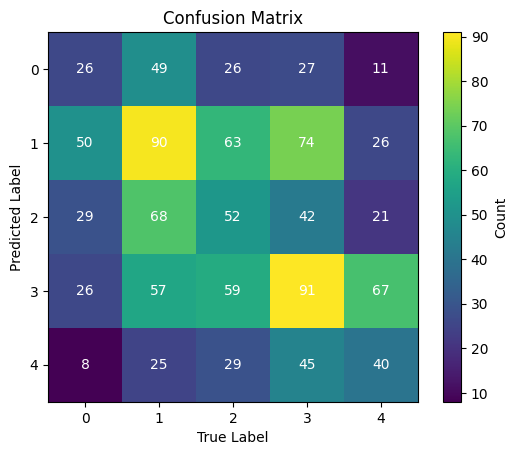

In [133]:
confusion_matrix = confusionMatrix(val_labels, predictions)
plotMatrix(confusion_matrix)

In [134]:
def performance(confusionMatrix):

  n = confusionMatrix.shape[0] #numberOfClasses
  precision = np.zeros(n)
  recall = np.zeros(n)
  f1_score = np.zeros(n)
  for i in range (0,n):
    precision[i] = confusionMatrix[i][i] / np.sum(confusionMatrix[:, i])
    recall[i] = confusionMatrix[i][i] / np.sum(confusionMatrix[i,:])
    f1_score[i] = 2*precision[i]*recall[i] / precision[i] + recall[i]

  macroaveraged_precision = np.sum(precision) / n
  macroaveraged_recall = np.sum(recall) / n
  macroaveraged_f1 = np.sum(f1_score) / n

  return precision, recall, f1_score, macroaveraged_precision, macroaveraged_recall, macroaveraged_f1

In [135]:
precision, recall, f1_score, macroaveraged_precision, macroaveraged_recall, macroaveraged_f1 = performance(confusion_matrix)

In [136]:
for i in range(5):
  print(f"Precision of class {i} is {precision[i]}")
  print(f"Recall of class {i} is {recall[i]}")
  print(f"f1 score of class {i} is {f1_score[i]}")
print(f"Macro averaged percision is {macroaveraged_precision} ")
print(f"Macro averaged recall is {macroaveraged_recall} ")
print(f"Macro averaged f1 score is {macroaveraged_f1} ")

Precision of class 0 is 0.18705035971223022
Recall of class 0 is 0.18705035971223022
f1 score of class 0 is 0.5611510791366907
Precision of class 1 is 0.31141868512110726
Recall of class 1 is 0.297029702970297
f1 score of class 1 is 0.891089108910891
Precision of class 2 is 0.22707423580786026
Recall of class 2 is 0.24528301886792453
f1 score of class 2 is 0.7358490566037736
Precision of class 3 is 0.32616487455197135
Recall of class 3 is 0.30333333333333334
f1 score of class 3 is 0.91
Precision of class 4 is 0.24242424242424243
Recall of class 4 is 0.272108843537415
f1 score of class 4 is 0.8163265306122449
Macro averaged percision is 0.2588264795234823 
Macro averaged recall is 0.26096105168424005 
Macro averaged f1 score is 0.7828831550527201 


In [137]:
predictions = model.predict(test_features)
print(f" Accuracy : {accuracy_score(test_labels, predictions)*100}")

 Accuracy : 27.058823529411764


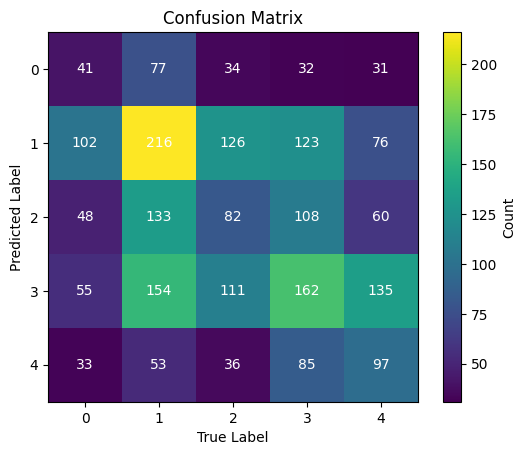

In [138]:
confusion_matrix = confusionMatrix(test_labels, predictions)
plotMatrix(confusion_matrix)

In [139]:
precision, recall, f1_score, macroaveraged_precision, macroaveraged_recall, macroaveraged_f1 = performance(confusion_matrix)

In [140]:
for i in range(5):
  print(f"Precision of class {i} is {precision[i]}")
  print(f"Recall of class {i} is {recall[i]}")
  print(f"f1 score of class {i} is {f1_score[i]}")
print(f"Macro averaged percision is {macroaveraged_precision} ")
print(f"Macro averaged recall is {macroaveraged_recall} ")
print(f"Macro averaged f1 score is {macroaveraged_f1} ")

Precision of class 0 is 0.14695340501792115
Recall of class 0 is 0.19069767441860466
f1 score of class 0 is 0.572093023255814
Precision of class 1 is 0.3412322274881517
Recall of class 1 is 0.3359253499222395
f1 score of class 1 is 1.0077760497667185
Precision of class 2 is 0.21079691516709512
Recall of class 2 is 0.1902552204176334
f1 score of class 2 is 0.5707656612529002
Precision of class 3 is 0.3176470588235294
Recall of class 3 is 0.2625607779578606
f1 score of class 3 is 0.7876823338735818
Precision of class 4 is 0.24310776942355888
Recall of class 4 is 0.3190789473684211
f1 score of class 4 is 0.9572368421052633
Macro averaged percision is 0.25194747518405125 
Macro averaged recall is 0.25970359401695187 
Macro averaged f1 score is 0.7791107820508556 


#SK-learn Model

In [ ]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(random_state = 42)
model.fit(train_features, train_labels)

In [103]:
predictions = model.predict(val_features)
print(f" Accuracy : {accuracy_score(val_labels, predictions)*100}")

 Accuracy : 36.6030881017257


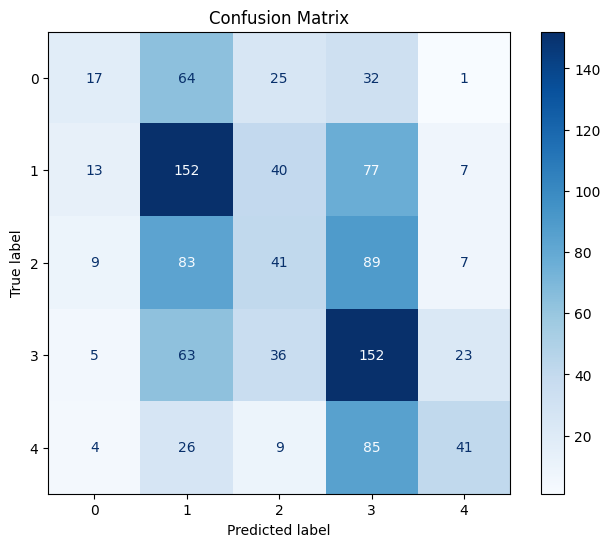

In [104]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

confusionMatrix = confusion_matrix(val_labels, predictions)
cm_display = ConfusionMatrixDisplay(confusion_matrix=confusionMatrix)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
cm_display.plot(ax=ax, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [105]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(val_labels, predictions, average='macro')  # or 'micro', 'weighted', 'samples', 'macro'
recall = recall_score(val_labels, predictions, average='macro')
f1 = f1_score(val_labels, predictions, average='macro')
print(f"precision: {precision}\n")
print(f"recall: {recall}\n")
print(f"f1_score: {f1}\n")

precision: 0.37717101038453504

recall: 0.3241161465090423

f1_score: 0.3216966838455487



In [106]:
predictions = model.predict(test_features)
print(f" Accuracy : {accuracy_score(test_labels, predictions)*100}")

 Accuracy : 35.47511312217195


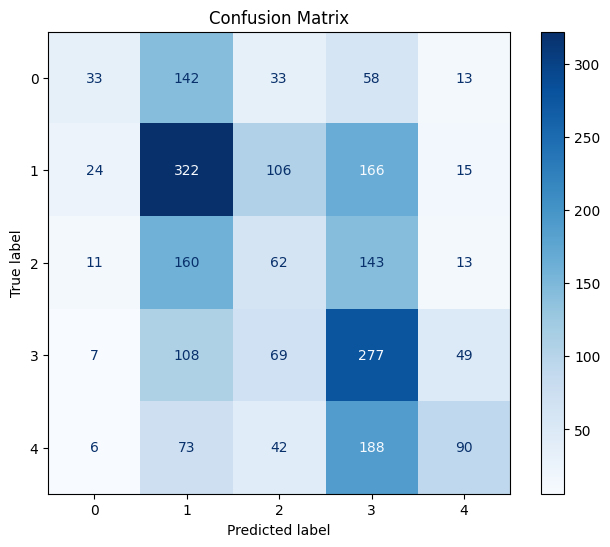

In [107]:
confusionMatrix = confusion_matrix(test_labels, predictions)
cm_display = ConfusionMatrixDisplay(confusion_matrix=confusionMatrix)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
cm_display.plot(ax=ax, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [108]:
precision = precision_score(test_labels, predictions, average='macro')  # or 'micro', 'weighted', 'samples', 'macro'
recall = recall_score(test_labels, predictions, average='macro')
f1 = f1_score(test_labels, predictions, average='macro')
print(f"precision: {precision}\n")
print(f"recall: {recall}\n")
print(f"f1_score: {f1}\n")

precision: 0.36781160968660964

recall: 0.3110105103116386

f1_score: 0.3063530477734714

